In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




import pydot

In [51]:
print(tf.__version__)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.12.0


In [52]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


Let us define methods to pre-process the tweets

In [53]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



In [54]:
train_data= pd.read_csv("/content/drive/MyDrive/TextClassificationTensorFlowCNN-master/train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)


test_data= pd.read_csv("/content/drive/MyDrive/TextClassificationTensorFlowCNN-master/test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Train data--------
negative    781
positive    753
neutral     310
Name: sentiment, dtype: int64
1844
-------------------------


<ipython-input-54-845c358b410f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['text'] = train_data['text'].apply(remove_emoji)
<ipython-input-54-845c358b410f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['text'] = train_data['text'].apply(remove_url)
<ipython-input-54-845c358b410f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

-------Test data--------
negative    193
positive    186
neutral      78
Name: sentiment, dtype: int64
457
-------------------------
Train Max Sentence Length :56
Test Max Sentence Length :55


Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

***
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
<br>
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
***

In [55]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[1, 29, 12, 44]]


In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=60)
x_valid = pad_sequences(x_valid, padding='post', maxlen=60)
x_test = pad_sequences(x_test, padding='post', maxlen=60)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


Train data len:1659
Class distributionCounter({'negative': 703, 'positive': 677, 'neutral': 279})
Valid data len:185
Class distributionCounter({'negative': 78, 'positive': 76, 'neutral': 31})
[2029  359 1200  433 1535 3857 3858  779  433   23 3859 1011 3860   80
 3861    8 2336 1032    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


<ipython-input-56-d1e4d4613ad7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train) )
<ipython-input-56-d1e4d4613ad7>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
<ipython-input-56-d1e4d4613ad7>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=objec

In [57]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['neutral', 'positive', 'neutral', 'positive', 'neutral', 'negative', 'positive', 'neutral', 'positive', 'positive']
Text to number
[1 2 1 2 1 0 2 1 2 2]
Number to category
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [58]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

======Train dataset ====
tf.Tensor(
[2029  359 1200  433 1535 3857 3858  779  433   23 3859 1011 3860   80
 3861    8 2336 1032    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(60,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[5054 5055    3 1115 5056 5057 5058    2 5059  627 5060    7  577 1042
 2781   85   18 5061   24   56    3 5062    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(60,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[   2   42  392    3  103   25  146 4823 4824  291 4825 4826 4827 2709
   41  932  254 4828    2 1797  945   54 1002 1874  368  616    2 4829
 4830 4831    0    0    0    0    0 

In [59]:
max_features =20000
embedding_dim =64
sequence_length = 60

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 64)            1280064   
                                                                 
 conv1d_4 (Conv1D)           (None, 58, 128)           24704     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
____________________________________________

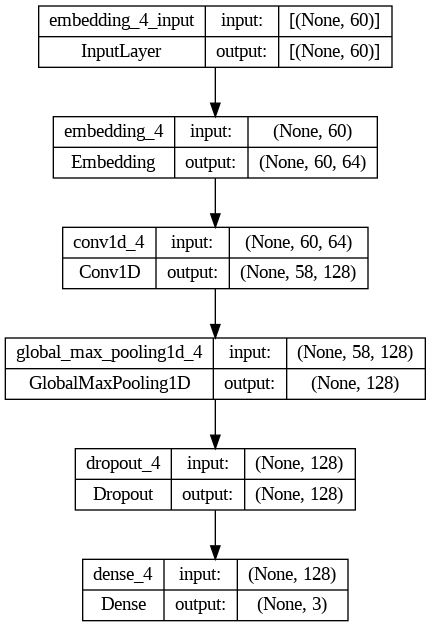

In [60]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Let's train our model

In [61]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 2s 33ms/step - loss: 1.5251 - categorical_accuracy: 0.4678 - val_loss: 1.3838 - val_categorical_accuracy: 0.5027
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 1.2834 - categorical_accuracy: 0.6028 - val_loss: 1.1954 - val_categorical_accuracy: 0.6865
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 1.1133 - categorical_accuracy: 0.6926 - val_loss: 1.0508 - val_categorical_accuracy: 0.7459
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.9456 - categorical_accuracy: 0.7746 - val_loss: 0.8828 - val_categorical_accuracy: 0.7784
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 0.7457 - categorical_accuracy: 0.8017 - val_loss: 0.6783 - val_categorical_accuracy: 0.7730
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.5356 - categorical_accuracy: 0.8740 - val_loss: 0.5203 - val_categorical_accuracy: 0.8811
Epoch 7/100
13/13 [==

In [31]:
history.history


{'loss': [1.1705842018127441,
  0.9643903970718384,
  0.7908053994178772,
  0.6189547181129456,
  0.43731099367141724,
  0.2803574502468109,
  0.19240786135196686,
  0.1503622978925705,
  0.12879373133182526,
  0.11464586108922958,
  0.10682673007249832,
  0.10183060169219971,
  0.09571954607963562,
  0.0901358425617218,
  0.08752404898405075,
  0.08363526314496994,
  0.07905465364456177,
  0.07697213441133499,
  0.07369235157966614,
  0.0706925094127655,
  0.07002320140600204,
  0.06747344136238098,
  0.06719499826431274,
  0.06503286212682724,
  0.06470762938261032,
  0.06359216570854187,
  0.06216316670179367,
  0.059571392834186554,
  0.06065121293067932,
  0.05873704329133034,
  0.05683264508843422,
  0.05689413473010063,
  0.05670582875609398,
  0.05505034327507019,
  0.055533234030008316,
  0.05645538866519928,
  0.05407487228512764,
  0.05526118725538254,
  0.054955534636974335,
  0.05234817788004875,
  0.05297015607357025,
  0.052658408880233765,
  0.0521019771695137,
  0.0525

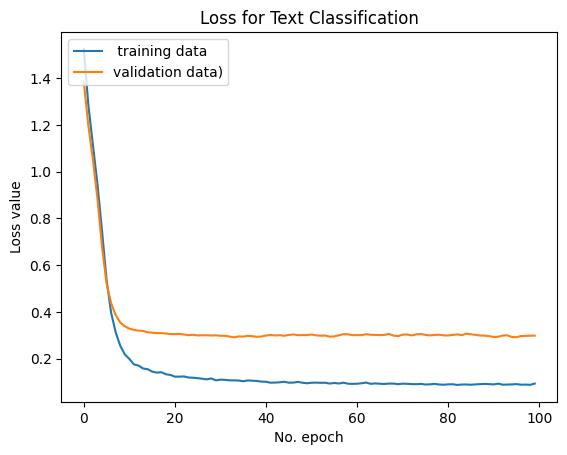

In [62]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Lets save our model and tokenizer

In [63]:
model.save('/content/drive/MyDrive/TextClassificationTensorFlowCNN-master/tf_cnnmodel') 
json_string = tokenizer.to_json()

In [64]:
import json
with open('/content/drive/MyDrive/TextClassificationTensorFlowCNN-master/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

Lets load our model and test on test data

In [65]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/TextClassificationTensorFlowCNN-master/tf_cnnmodel')
new_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 64)            1280064   
                                                                 
 conv1d_4 (Conv1D)           (None, 58, 128)           24704     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
____________________________________________

In [66]:
with open('/content/drive/MyDrive/TextClassificationTensorFlowCNN-master/tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [67]:
x_test  = np.array( tokenizer1.texts_to_sequences(test_data['text'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=60)

<ipython-input-67-7d143950dccd>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer1.texts_to_sequences(test_data['text'].tolist()) )


In [68]:

# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)


Generate predictions for all samples
15/15 [==============================] - 0s 4ms/step
[[0.99244976 0.00677486 0.2095574 ]
 [0.9858575  0.02982821 0.12823054]
 [0.04676104 0.06105558 0.99389863]
 ...
 [0.03808217 0.02487185 0.9977132 ]
 [0.04964581 0.02170193 0.9962521 ]
 [0.973808   0.22245204 0.02408383]]


In [74]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)

In [75]:
test_data['pred_sentiment'].value_counts()

positive    185
negative    173
neutral      99
Name: pred_sentiment, dtype: int64

In [76]:
labels = ['positive', 'negative','neutral']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.97      0.97      0.97       186
    negative       0.98      0.88      0.92       193
     neutral       0.74      0.94      0.82        78

    accuracy                           0.92       457
   macro avg       0.90      0.93      0.91       457
weighted avg       0.93      0.92      0.93       457

